<a href="https://colab.research.google.com/github/imvladikon/quora-question-pair/blob/xgboost_66/XGBoost_from_begining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,\
        precision_score, recall_score, f1_score, roc_auc_score,auc, \
average_precision_score,precision_recall_curve, \
classification_report, roc_curve,confusion_matrix
 
from scipy.spatial.distance import cosine
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [5]:
def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for 
    the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.loc[fpr_tpr.dist.idxmin(), 'thresholds']


def get_model_results(model, X_train, X_test, y_train, y_test, title):
    """ gets model,train and test sets with labels
    returns the AUC-ROC plot for train and test sets 
    and classification_report
    
    **Note:** only for binary classification
    """
    #find_best_threshold and predict_proba X_test
    probabilities = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities > threshold
    
    fig = plt.figure(figsize = (18,5))
    # calculate precision-recall curve
    precision, recall, thresholds = \
    precision_recall_curve(y_test,probabilities, pos_label=1)
    precision, recall = np.round(precision, 2), np.round(recall, 2)
    # average precision score
    avg_precision = average_precision_score(y_test,probabilities,pos_label=1)
    # precision auc
    pr_auc = auc(recall, precision)
    
    #PR Curve X_Test
    ax1 = plt.subplot(121)
    ax1.plot(recall, precision, lw=1, color='blue', 
             label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
    plt.fill_between(recall, precision,-1, 
                     facecolor='lightblue', alpha=0.5)
    plt.xlabel('Recall (TPR)')
    plt.ylim(0,1)

    plt.ylabel('Precision')
    plt.legend(loc="best")
    plt.title(f'PR Curve for {title}');

     
    # calculate AUC-ROC curve for X_test
    fpr, tpr, thresholds = roc_curve(y_test,probabilities,pos_label=1)
    roc_auc = auc(fpr, tpr)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    ax2 = plt.subplot(122)
    ax2.plot(fpr, tpr, lw=1, color='red',
             label=f"AUC-ROC X_Test= {round(roc_auc,4)}") 
    
    # calculate AUC-ROC curve for X_Train
    probabilities_train = model.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities_train)
    
    ax2.plot(fpr, tpr, label='X_Train')
    ax2.plot(ns_fpr, ns_tpr, color='grey',
             linestyle='--', label='Baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc="best")
    plt.title(f'AUC-ROC Curve for {title}');
    
    print(classification_report(y_test, predictions))

Load the data and check the shape

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_dup.csv')
df.shape


(404290, 6)

Let's see what we have:

In [ ]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


Drop unused columns, duplicated rows and rows with Nan

In [ ]:
df = df.dropna().drop_duplicates().drop(['qid1', 'qid2', 'id'], axis=1)
df.shape

(404287, 3)

We lost only 3 rows as nan and duplicated - that's good

In [ ]:
df

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...
404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,What is one coin?,What's this coin?,0
404288,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


Check statistics for target feature

In [ ]:
df.describe()

,is_duplicate
count,404287.000000
mean,0.369201
std,0.482589
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Plot the distribution of the target feature

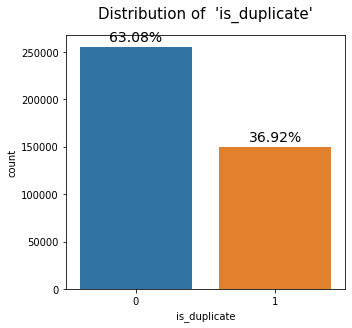

In [ ]:
plt.figure(figsize=(5,3))
bar = sns.countplot(x='is_duplicate', data=df)
plt.text(0.5, 298000,"Distribution of  'is_duplicate'",
     horizontalalignment='center',
     verticalalignment='top',
        fontsize=15)
plt.subplots_adjust(top=1.3)
for p in bar.patches:
        bar.annotate('{}%'.format(round(p.get_height()/len(df)*100,2), '.2f'), \
                       (p.get_x() + p.get_width() / 2.,p.get_height()),ha = 'center', \
                       va = 'center',xytext = (0, 10),textcoords = 'offset points',size = 14);

Data is unballanced we can leave it like it is and later on try to undersemple it and compare results<br>
Here the link about XGBoost classifier and imballansed data:
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/<br>
Before cleaning the text, we preview a few question pairs to determine how to clean them.

In [ ]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

 After some inspections, a few tries and ideas from https://www.kaggle.com/currie32/the-importance-of-cleaning-text and https://towardsdatascience.com/finding-similar-quora-questions-with-bow-tfidf-and-random-forest-c54ad88d1370 , I decided to clean the text as follows:

* Not to remove stop words, because words like “what”, “which” and “how” may have strong signals.
* Not to stem words.
* Remove punctuation.
* Correct typos.
* Change abbreviations to its original terms.
* Remove comma between numbers.
* Change special chars to words. And so on.


In [ ]:

SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def pad_str(s):
  return ' '+s+' '
    
    
def clean(text, stem_words=True):

  if pd.isnull(text):
    return ''

  # Empty question
  if type(text) != str or text=='':
    return ''

  # Clean the text
  text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
  text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
  text = re.sub("\'ve", " have ", text)
  text = re.sub("can't", "can not", text)
  text = re.sub("n't", " not ", text)
  text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
  text = re.sub("\'re", " are ", text)
  text = re.sub("\'d", " would ", text)
  text = re.sub("\'ll", " will ", text)
  text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
  text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
  text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
  text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
  text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
  text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
  text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
  text = re.sub("[c-fC-F]\:\/", " disk ", text)

  # remove comma between numbers, i.e. 15,000 -> 15000
  text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

  # add padding to punctuations and special chars, we still need them later
  text = re.sub('\$', " dollar ", text)
  text = re.sub('\%', " percent ", text)
  text = re.sub('\&', " and ", text)

# replace non-ascii word with special word
  text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text)     
    
  # indian dollar
  text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
  text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)

  # indian dollar
  text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
  text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    

# clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
  text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
  text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
  text = re.sub(r" india ", " India ", text)
  text = re.sub(r" switzerland ", " Switzerland ", text)
  text = re.sub(r" china ", " China ", text)
  text = re.sub(r" chinese ", " Chinese ", text) 
  text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
  text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
  text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
  text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
  text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
  text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
  text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
  text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
  text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
  text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
  text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
  text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
  text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
  text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
  text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
  text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
  text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
  text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
  text = re.sub(r" III ", " 3 ", text)
  text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
  text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
  text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)


  # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
  text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
  # Remove punctuation from text
  text = ''.join([c for c in text if c not in punctuation]).lower()
  # Return a list of words
  return text

df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

After cleaning text, we preview those question pairs again.

In [ ]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

Much better

# Xgboost Model + CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from sklearn.metrics import f1_score, classification_report, accuracy_score


### CountVectorizer

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.1)


### XGBClassifier

In [ ]:


xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, 
                              learning_rate=0.1, colsample_bytree=.7, 
                              gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1, subsample=0.8) 
xgb_model.fit(X_train, y_train, 
              early_stopping_rounds=3, 
              eval_metric=["error", "logloss"], 
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              verbose=True)
                              
y_pred = xgb_model.predict(X_test)


[0]	validation_0-error:0.251474	validation_0-logloss:0.662132	validation_1-error:0.277994	validation_1-logloss:0.665848
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.236524	validation_0-logloss:0.638101	validation_1-error:0.266294	validation_1-logloss:0.644654
[2]	validation_0-error:0.230362	validation_0-logloss:0.61694	validation_1-error:0.260407	validation_1-logloss:0.626396
[3]	validation_0-error:0.227207	validation_0-logloss:0.598575	validation_1-error:0.2564	validation_1-logloss:0.610435
[4]	validation_0-error:0.223109	validation_0-logloss:0.581568	validation_1-error:0.252245	validation_1-logloss:0.595847
[5]	validation_0-error:0.222109	validation_0-logloss:0.567272	validation_1-error:0.251453	validation_1-logloss:0.584072
[6]	validation_0-error:0.218214	validation_0-logloss:0.552719	validation_1-error:0.248831	validation_1-logloss:0.57197

In [ ]:

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('test score:', f1_score(y_test,y_pred, average='macro'))
print(classification_report(y_test, y_pred))

training score: 0.8312751583315067
test score: 0.7668291065818726
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     25287
           1       0.79      0.61      0.69     15142

    accuracy                           0.79     40429
   macro avg       0.79      0.76      0.77     40429
weighted avg       0.79      0.79      0.79     40429



Model scores with perfect threshold

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     25287
           1       0.70      0.77      0.74     15142

    accuracy                           0.79     40429
   macro avg       0.78      0.79      0.78     40429
weighted avg       0.80      0.79      0.79     40429



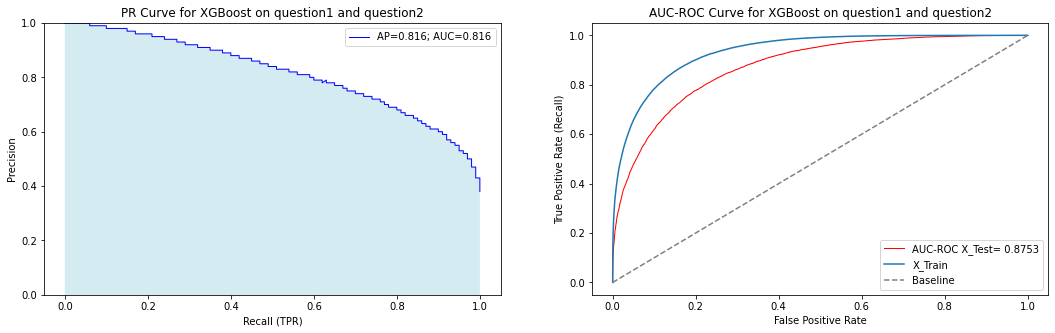

In [ ]:
get_model_results(xgb_model, X_train, X_test, y_train, y_test, "XGBoost on question1 and question2")

Duplicating previouse step to play with 
### scale_pos_weight

Here we try to deal with imballanced target feature

In [ ]:
#scale_pos_w =  total_negative_examples / total_positive_examples
scale_pos_w = df.is_duplicate[df.is_duplicate ==0].count()/df.is_duplicate[df.is_duplicate ==1].count()
scale_pos_w

1.7085546987532074

In [ ]:

xgb_model = XGBClassifier(max_depth=50, n_estimators=80, 
                              learning_rate=0.1, colsample_bytree=.7, 
                              gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1,scale_pos_weight =scale_pos_w, subsample=0.8)


xgb_model.fit(X_train, y_train, 
              early_stopping_rounds=3, 
              eval_metric=["error", "logloss"], 
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              verbose=True)

y_pred = xgb_model.predict(X_test)

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('test score:', f1_score(y_test,y_pred, average='macro'))
print(classification_report(y_test, y_pred))


[0]	validation_0-error:0.259315	validation_0-logloss:0.665519	validation_1-error:0.29934	validation_1-logloss:0.66988
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.227586	validation_0-logloss:0.641015	validation_1-error:0.273418	validation_1-logloss:0.649613
[2]	validation_0-error:0.22165	validation_0-logloss:0.619652	validation_1-error:0.270474	validation_1-logloss:0.632558
[3]	validation_0-error:0.209414	validation_0-logloss:0.601241	validation_1-error:0.260036	validation_1-logloss:0.61744
[4]	validation_0-error:0.202983	validation_0-logloss:0.584329	validation_1-error:0.252838	validation_1-logloss:0.603696
[5]	validation_0-error:0.198844	validation_0-logloss:0.569125	validation_1-error:0.249746	validation_1-logloss:0.592139
[6]	validation_0-error:0.191723	validation_0-logloss:0.553487	validation_1-error:0.244626	validation_1-logloss:0.579679

Model's scores with perfect threshold

              precision    recall  f1-score   support

           0       0.86      0.79      0.82     25287
           1       0.69      0.79      0.74     15142

    accuracy                           0.79     40429
   macro avg       0.78      0.79      0.78     40429
weighted avg       0.80      0.79      0.79     40429



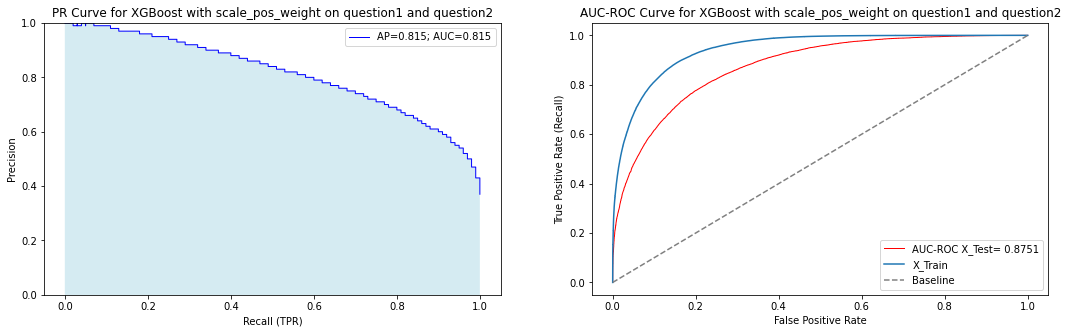

In [ ]:
get_model_results(xgb_model, X_train, X_test, y_train, y_test, "XGBoost with scale_pos_weight on question1 and question2")

We see an overfit here, let's make cross-validation


## Evaluate XGBoost Model With k-Fold Cross Validation

p.s. it was not a good idea - too much folds and too much data

In [ ]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)


# params = {
#     # Parameters that we are going to tune.
#     'max_depth':50,
#     'n_estimators':80,
#     'eta':.3,
#     'subsample': 0.8,
#     'colsample_bytree': .7,
#     'learning_rate':0.1,
#     'scale_pos_weight':scale_pos_w,
#     # Other parameters
#     'objective':'binary:logistic',
#     'silent':1,
#     'gamma':0,
#     'reg_alpha':4,


# }


# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=999,
#     nfold=10,
#     metrics={"error", "logloss"},
#     early_stopping_rounds=10,
#     as_pandas=True,
#     verbose_eval =1
# )
# cv_results

# [0]	train-error:0.242035+0.00173525	train-logloss:0.663344+0.000122287	test-error:0.291479+0.0024162	test-logloss:0.668995+0.000269579
# [1]	train-error:0.223927+0.00337186	train-logloss:0.640085+0.00094844	test-error:0.274942+0.00381408	test-logloss:0.64925+0.000798581
# [2]	train-error:0.212526+0.00277382	train-logloss:0.618912+0.00102374	test-error:0.264175+0.00238594	test-logloss:0.63179+0.00103798
# [3]	train-error:0.205665+0.00237187	train-logloss:0.600084+0.00140989	test-error:0.257991+0.00251498	test-logloss:0.616585+0.00123789
# [4]	train-error:0.200316+0.00138819	train-logloss:0.583538+0.00148107	test-error:0.252777+0.00200703	test-logloss:0.603319+0.00119625
# [5]	train-error:0.196058+0.0017411	train-logloss:0.568253+0.00176744	test-error:0.249559+0.00222038	test-logloss:0.591292+0.00122434
# [6]	train-error:0.192742+0.00127608	train-logloss:0.555286+0.0018094	test-error:0.247218+0.00213389	test-logloss:0.58109+0.0010272
# [7]	train-error:0.189947+0.00151535	train-logloss:0.543204+0.00235766	test-error:0.245104+0.00228398	test-logloss:0.57187+0.00151045
# [8]	train-error:0.187183+0.00133858	train-logloss:0.531462+0.00221579	test-error:0.243265+0.00216278	test-logloss:0.563055+0.00132818
# [9]	train-error:0.18483+0.00104198	train-logloss:0.521039+0.00199762	test-error:0.241602+0.00235904	test-logloss:0.555319+0.00136321
# [10]	train-error:0.182689+0.0012425	train-logloss:0.511963+0.00185978	test-error:0.240014+0.00277047	test-logloss:0.548561+0.00140723
# [11]	train-error:0.180429+0.00114556	train-logloss:0.503187+0.00148093	test-error:0.238475+0.00276622	test-logloss:0.542266+0.00118038
# [12]	train-error:0.178475+0.00119731	train-logloss:0.495187+0.00144303	test-error:0.23765+0.00246908	test-logloss:0.536447+0.00160243
# [13]	train-error:0.176627+0.00114728	train-logloss:0.487751+0.00173063	test-error:0.236551+0.00265375	test-logloss:0.531104+0.00178723
# [14]	train-error:0.174724+0.00106369	train-logloss:0.48096+0.0017732	test-error:0.23535+0.00259173	test-logloss:0.526346+0.00199371
# [15]	train-error:0.173262+0.00111073	train-logloss:0.474884+0.00139419	test-error:0.234363+0.00262237	test-logloss:0.522029+0.00205927
# [16]	train-error:0.171844+0.0011769	train-logloss:0.469426+0.00160376	test-error:0.233539+0.00271313	test-logloss:0.518207+0.00196586
# [17]	train-error:0.170858+0.00116655	train-logloss:0.464423+0.00152531	test-error:0.232871+0.00266014	test-logloss:0.514646+0.00194049
# [18]	train-error:0.169326+0.00136021	train-logloss:0.459179+0.0012397	test-error:0.231967+0.00266548	test-logloss:0.511031+0.00179155
# [19]	train-error:0.16823+0.00118799	train-logloss:0.454846+0.00159471	test-error:0.2312+0.00262499	test-logloss:0.507984+0.00195044
# [20]	train-error:0.167085+0.00134095	train-logloss:0.45059+0.00161434	test-error:0.230486+0.00284439	test-logloss:0.50511+0.0019929
# [21]	train-error:0.165876+0.00128554	train-logloss:0.44654+0.00161371	test-error:0.229801+0.0025039	test-logloss:0.502352+0.00195058
# [22]	train-error:0.164712+0.00124882	train-logloss:0.442818+0.00194949	test-error:0.229054+0.00243237	test-logloss:0.499804+0.00196817
# [23]	train-error:0.163402+0.00114986	train-logloss:0.438677+0.00165236	test-error:0.228477+0.00232949	test-logloss:0.497041+0.00170898
# [24]	train-error:0.162687+0.00122672	train-logloss:0.435941+0.00194561	test-error:0.227968+0.00244935	test-logloss:0.495143+0.00180691
# [25]	train-error:0.16194+0.00122055	train-logloss:0.433321+0.0017881	test-error:0.227361+0.00240782	test-logloss:0.493264+0.00189886
# [26]	train-error:0.161101+0.00115048	train-logloss:0.430482+0.00194393	test-error:0.226836+0.00237234	test-logloss:0.491303+0.00180442
# [27]	train-error:0.160325+0.00102523	train-logloss:0.427915+0.00196473	test-error:0.226396+0.00252039	test-logloss:0.489546+0.00195058
# [28]	train-error:0.159439+0.000965376	train-logloss:0.425163+0.0014078	test-error:0.225709+0.00252629	test-logloss:0.487629+0.00183898
# [29]	train-error:0.15876+0.00103969	train-logloss:0.422882+0.00150419	test-error:0.225357+0.00245736	test-logloss:0.486083+0.00179909
# [30]	train-error:0.157896+0.00113965	train-logloss:0.420386+0.00140312	test-error:0.224673+0.00271722	test-logloss:0.484436+0.00191079
# [31]	train-error:0.157242+0.00111908	train-logloss:0.418315+0.00124794	test-error:0.2242+0.00270139	test-logloss:0.483032+0.00181746
# [32]	train-error:0.156616+0.00100174	train-logloss:0.416378+0.00140182	test-error:0.223736+0.00270712	test-logloss:0.481696+0.00175578
# [33]	train-error:0.156099+0.000918194	train-logloss:0.414664+0.00153408	test-error:0.223389+0.00255438	test-logloss:0.480531+0.00187331
# [34]	train-error:0.155469+0.000807196	train-logloss:0.413033+0.00152885	test-error:0.222865+0.00247768	test-logloss:0.479438+0.00180219
# [35]	train-error:0.154824+0.000661413	train-logloss:0.411195+0.0013423	test-error:0.222414+0.00250218	test-logloss:0.478159+0.00199476
# [36]	train-error:0.154271+0.000653126	train-logloss:0.409714+0.00142111	test-error:0.222117+0.00237777	test-logloss:0.477205+0.00206133
# [37]	train-error:0.153557+0.000808939	train-logloss:0.407881+0.00183056	test-error:0.221383+0.0026093	test-logloss:0.475978+0.0023569
# [38]	train-error:0.152841+0.000802988	train-logloss:0.405844+0.00153001	test-error:0.220908+0.00257058	test-logloss:0.47467+0.00244827
# [39]	train-error:0.152293+0.000853987	train-logloss:0.40438+0.0016599	test-error:0.220591+0.00227328	test-logloss:0.473678+0.00228731
# [40]	train-error:0.151679+0.000812559	train-logloss:0.402918+0.00153279	test-error:0.220155+0.0022777	test-logloss:0.472681+0.00227138
# [41]	train-error:0.15117+0.000722568	train-logloss:0.401522+0.00145759	test-error:0.219687+0.00228323	test-logloss:0.47171+0.00212745
# [42]	train-error:0.150651+0.000682324	train-logloss:0.400288+0.00152615	test-error:0.219401+0.00239833	test-logloss:0.470846+0.00219103
# [43]	train-error:0.150135+0.000650163	train-logloss:0.398962+0.00153389	test-error:0.219121+0.00232543	test-logloss:0.469995+0.00214176
# [44]	train-error:0.149571+0.000413252	train-logloss:0.397496+0.00144743	test-error:0.218885+0.00238911	test-logloss:0.469065+0.00209787
# [45]	train-error:0.148999+0.000545589	train-logloss:0.396173+0.00181296	test-error:0.218555+0.00236005	test-logloss:0.468204+0.00218353
# [46]	train-error:0.148598+0.000586982	train-logloss:0.395201+0.00187202	test-error:0.218302+0.00246388	test-logloss:0.467545+0.00218221
# [47]	train-error:0.148137+0.000616806	train-logloss:0.394148+0.00171028	test-error:0.218005+0.00244892	test-logloss:0.46685+0.00222369
# [48]	train-error:0.14761+0.000731248	train-logloss:0.392894+0.00171613	test-error:0.217571+0.00231922	test-logloss:0.466046+0.00215817
# [49]	train-error:0.147261+0.000705332	train-logloss:0.392036+0.00162131	test-error:0.217288+0.0023898	test-logloss:0.46544+0.00219147
# [50]	train-error:0.146751+0.00071452	train-logloss:0.39083+0.00165363	test-error:0.216944+0.00237117	test-logloss:0.464646+0.00214049
# [51]	train-error:0.146403+0.000705293	train-logloss:0.38996+0.00158442	test-error:0.216683+0.00233179	test-logloss:0.464061+0.00214016
# [52]	train-error:0.145993+0.000707304	train-logloss:0.38886+0.00147499	test-error:0.216376+0.0023414	test-logloss:0.463312+0.00230142
# [53]	train-error:0.145642+0.000725857	train-logloss:0.388063+0.00156285	test-error:0.216148+0.00236311	test-logloss:0.462759+0.00228945
# [54]	train-error:0.145097+0.000816719	train-logloss:0.386916+0.00170872	test-error:0.215829+0.00236397	test-logloss:0.462052+0.00227829
# [55]	train-error:0.144427+0.000682634	train-logloss:0.385532+0.00139184	test-error:0.215414+0.00234863	test-logloss:0.461204+0.00205507
# [56]	train-error:0.144047+0.000649812	train-logloss:0.384558+0.00140022	test-error:0.215139+0.00248409	test-logloss:0.460545+0.00201718
# [57]	train-error:0.143626+0.000672649	train-logloss:0.383636+0.00144073	test-error:0.214894+0.00248106	test-logloss:0.459928+0.00210091
# [58]	train-error:0.143231+0.000752332	train-logloss:0.382812+0.00145091	test-error:0.214636+0.00242033	test-logloss:0.459342+0.00208187
# [59]	train-error:0.142804+0.000866622	train-logloss:0.381872+0.00156041	test-error:0.214325+0.00241533	test-logloss:0.458725+0.00209119
# [60]	train-error:0.14247+0.000846621	train-logloss:0.381075+0.00153932	test-error:0.214048+0.00247024	test-logloss:0.458186+0.00214664
# [61]	train-error:0.142088+0.000751808	train-logloss:0.380249+0.00152791	test-error:0.213844+0.0024634	test-logloss:0.457663+0.00205056
# [62]	train-error:0.1417+0.000767987	train-logloss:0.379358+0.00145159	test-error:0.213586+0.00249933	test-logloss:0.45705+0.00216076
# [63]	train-error:0.141361+0.000755759	train-logloss:0.378608+0.00134027	test-error:0.213314+0.00261802	test-logloss:0.456561+0.00227236
# [64]	train-error:0.140976+0.000716526	train-logloss:0.377761+0.00131093	test-error:0.212957+0.00265798	test-logloss:0.455993+0.00219499
# [65]	train-error:0.140644+0.00077158	train-logloss:0.37703+0.00144745	test-error:0.212759+0.00271977	test-logloss:0.455518+0.0022707
# [66]	train-error:0.140349+0.000696622	train-logloss:0.376355+0.00146514	test-error:0.212534+0.00276357	test-logloss:0.455061+0.00226561
# [67]	train-error:0.140012+0.00068346	train-logloss:0.375476+0.00149814	test-error:0.212228+0.00273592	test-logloss:0.454492+0.00220802
# [68]	train-error:0.139521+0.000612805	train-logloss:0.374398+0.00148682	test-error:0.211956+0.00251774	test-logloss:0.453842+0.00214228
# [69]	train-error:0.139122+0.000628674	train-logloss:0.373602+0.00139231	test-error:0.211717+0.00246388	test-logloss:0.45332+0.00227151
# [70]	train-error:0.138688+0.00069331	train-logloss:0.372619+0.00179512	test-error:0.21158+0.00242249	test-logloss:0.452736+0.00228609
# [71]	train-error:0.138343+0.00067664	train-logloss:0.371812+0.0017987	test-error:0.211486+0.0024594	test-logloss:0.452236+0.00228719
# [72]	train-error:0.13801+0.000659997	train-logloss:0.37113+0.00160554	test-error:0.211289+0.00230531	test-logloss:0.451833+0.0022769
# [73]	train-error:0.137785+0.000671639	train-logloss:0.370612+0.00162402	test-error:0.211145+0.00228299	test-logloss:0.451477+0.00220496
# [74]	train-error:0.137477+0.000671242	train-logloss:0.369912+0.00167174	test-error:0.210882+0.00211642	test-logloss:0.451041+0.00224564
# [75]	train-error:0.137237+0.000650165	train-logloss:0.369373+0.00157737	test-error:0.210764+0.00213806	test-logloss:0.450676+0.00227501
# [76]	train-error:0.136912+0.000672699	train-logloss:0.368762+0.00168057	test-error:0.210607+0.00212645	test-logloss:0.450293+0.00224976
# [77]	train-error:0.136528+0.000676975	train-logloss:0.368028+0.00147127	test-error:0.210436+0.00208781	test-logloss:0.449835+0.00226654
# [78]	train-error:0.136028+0.000747887	train-logloss:0.367139+0.00148844	test-error:0.210096+0.00218573	test-logloss:0.449309+0.00237231
# [79]	train-error:0.135672+0.000786262	train-logloss:0.366467+0.00154715	test-error:0.209906+0.00218177	test-logloss:0.448905+0.00229863
# [80]	train-error:0.135427+0.000822693	train-logloss:0.365885+0.00166646	test-error:0.209738+0.00220908	test-logloss:0.448529+0.00226879
# [81]	train-error:0.135045+0.000827382	train-logloss:0.365082+0.00162979	test-error:0.209444+0.00217062	test-logloss:0.448044+0.00220173
# [82]	train-error:0.134645+0.000914766	train-logloss:0.36427+0.0018495	test-error:0.209128+0.00215333	test-logloss:0.447538+0.00222681
# [83]	train-error:0.134336+0.000964148	train-logloss:0.363649+0.0019588	test-error:0.208883+0.00215833	test-logloss:0.447166+0.00222146
# [84]	train-error:0.134022+0.00095243	train-logloss:0.363035+0.00194097	test-error:0.208664+0.00201773	test-logloss:0.446776+0.00215725
# [85]	train-error:0.13371+0.000932293	train-logloss:0.362412+0.0019437	test-error:0.20851+0.00193456	test-logloss:0.446363+0.00212179
# [86]	train-error:0.133396+0.000931278	train-logloss:0.361845+0.00190314	test-error:0.208279+0.00190954	test-logloss:0.446021+0.00215678
# [87]	train-error:0.133162+0.000930793	train-logloss:0.361311+0.00195654	test-error:0.208175+0.00192825	test-logloss:0.445677+0.00214036
# [88]	train-error:0.132813+0.00102419	train-logloss:0.360652+0.00216517	test-error:0.207977+0.0019267	test-logloss:0.445287+0.00215152
# [89]	train-error:0.132544+0.00103074	train-logloss:0.360048+0.00224155	test-error:0.207869+0.00185152	test-logloss:0.444928+0.00208855
# [90]	train-error:0.132214+0.00100073	train-logloss:0.359373+0.00216504	test-error:0.207581+0.00188664	test-logloss:0.444517+0.00208939
# [91]	train-error:0.131944+0.000981335	train-logloss:0.358717+0.00221698	test-error:0.207347+0.0019761	test-logloss:0.444106+0.00211196
# [92]	train-error:0.13155+0.00102295	train-logloss:0.357921+0.0023177	test-error:0.207138+0.00191279	test-logloss:0.443631+0.00199233
# [93]	train-error:0.13129+0.00100861	train-logloss:0.357336+0.00231612	test-error:0.206974+0.00185032	test-logloss:0.443261+0.00199589
# [94]	train-error:0.130998+0.000890242	train-logloss:0.356647+0.00216598	test-error:0.20671+0.00187292	test-logloss:0.442821+0.00205329
# [95]	train-error:0.130718+0.000953049	train-logloss:0.356046+0.00231434	test-error:0.206581+0.00181491	test-logloss:0.44246+0.00207187
# [96]	train-error:0.130521+0.000944015	train-logloss:0.355623+0.00234435	test-error:0.206479+0.00188791	test-logloss:0.4422+0.00209028
# [97]	train-error:0.130185+0.0010189	train-logloss:0.354926+0.00234943	test-error:0.206155+0.00185664	test-logloss:0.441781+0.00220431
# [98]	train-error:0.129869+0.00105884	train-logloss:0.354266+0.00227397	test-error:0.206004+0.00184794	test-logloss:0.441362+0.00224611
# [99]	train-error:0.129621+0.00104233	train-logloss:0.353782+0.00229473	test-error:0.205841+0.00182966	test-logloss:0.441081+0.0022104
# [100]	train-error:0.129284+0.00092232	train-logloss:0.353172+0.00200113	test-error:0.205687+0.00178541	test-logloss:0.44073+0.00229664
# [101]	train-error:0.128961+0.000950176	train-logloss:0.352564+0.00208281	test-error:0.205473+0.00179221	test-logloss:0.440365+0.0022697
# [102]	train-error:0.128613+0.00103574	train-logloss:0.351896+0.0022513	test-error:0.205264+0.00185374	test-logloss:0.439973+0.00232207
# [103]	train-error:0.128347+0.00101563	train-logloss:0.351387+0.00215836	test-error:0.205182+0.001871	test-logloss:0.439688+0.00229847
# [104]	train-error:0.128051+0.00103691	train-logloss:0.350707+0.00204063	test-error:0.20516+0.00179161	test-logloss:0.439288+0.00240517
# [105]	train-error:0.127716+0.000945217	train-logloss:0.35006+0.00199658	test-error:0.204959+0.0018417	test-logloss:0.438926+0.00239502
# [106]	train-error:0.12749+0.000961655	train-logloss:0.349568+0.00207469	test-error:0.204833+0.00180901	test-logloss:0.438638+0.00237754
# [107]	train-error:0.127232+0.00102032	train-logloss:0.349041+0.00217399	test-error:0.204731+0.00185493	test-logloss:0.43832+0.00240298
# [108]	train-error:0.126861+0.00108647	train-logloss:0.348267+0.00222204	test-error:0.204492+0.00191669	test-logloss:0.437904+0.00247618
# [109]	train-error:0.126533+0.00105582	train-logloss:0.347656+0.00213755	test-error:0.204374+0.00184396	test-logloss:0.437561+0.00240582
# [110]	train-error:0.126211+0.00113196	train-logloss:0.347049+0.00230983	test-error:0.20425+0.00194474	test-logloss:0.437234+0.00242919
# [111]	train-error:0.126024+0.00112316	train-logloss:0.346633+0.00225905	test-error:0.204068+0.00197256	test-logloss:0.43696+0.00241771
# [112]	train-error:0.125673+0.00129147	train-logloss:0.345893+0.00256205	test-error:0.203871+0.00205829	test-logloss:0.436553+0.00258345
# [113]	train-error:0.125427+0.00126703	train-logloss:0.345417+0.00255695	test-error:0.203807+0.00204998	test-logloss:0.436279+0.00257227
# [114]	train-error:0.125047+0.0011812	train-logloss:0.344747+0.00241967	test-error:0.203505+0.00191292	test-logloss:0.435917+0.00249014
# [115]	train-error:0.124815+0.00120308	train-logloss:0.34431+0.00241512	test-error:0.203401+0.00198518	test-logloss:0.43565+0.00248525
# [116]	train-error:0.124554+0.00125968	train-logloss:0.343773+0.00251884	test-error:0.203189+0.00199278	test-logloss:0.435345+0.00248983
# [117]	train-error:0.124266+0.00129366	train-logloss:0.343261+0.00252897	test-error:0.203079+0.00199824	test-logloss:0.435056+0.00250319
# [118]	train-error:0.123903+0.00115471	train-logloss:0.342569+0.00236244	test-error:0.202969+0.00194619	test-logloss:0.43468+0.00247528
# [119]	train-error:0.123438+0.00134496	train-logloss:0.341742+0.00257297	test-error:0.202623+0.0018903	test-logloss:0.434229+0.0024362
# [120]	train-error:0.123152+0.00130431	train-logloss:0.341164+0.00248306	test-error:0.202367+0.0018335	test-logloss:0.433905+0.00230912
# [121]	train-error:0.122972+0.00131968	train-logloss:0.340727+0.00254148	test-error:0.20231+0.00190055	test-logloss:0.43365+0.00228548
# [122]	train-error:0.122429+0.00123627	train-logloss:0.339769+0.00266034	test-error:0.202148+0.00192812	test-logloss:0.433187+0.00221862
# [123]	train-error:0.122126+0.00125557	train-logloss:0.339138+0.00272241	test-error:0.202065+0.0019627	test-logloss:0.432826+0.00215908
# [124]	train-error:0.121929+0.00123986	train-logloss:0.338613+0.00263567	test-error:0.201914+0.00191548	test-logloss:0.432517+0.00198325
# [125]	train-error:0.121511+0.00106754	train-logloss:0.337831+0.00235118	test-error:0.201735+0.00194213	test-logloss:0.432119+0.00199277
# [126]	train-error:0.121211+0.00112438	train-logloss:0.33732+0.00232351	test-error:0.201716+0.00202115	test-logloss:0.431855+0.00196527
# [127]	train-error:0.120956+0.00117532	train-logloss:0.336798+0.00239128	test-error:0.20154+0.00200949	test-logloss:0.431574+0.00192086
# [128]	train-error:0.120729+0.00107805	train-logloss:0.336331+0.00217924	test-error:0.201392+0.00196481	test-logloss:0.431296+0.0019987
# [129]	train-error:0.120429+0.00112218	train-logloss:0.335785+0.00209389	test-error:0.201285+0.00192727	test-logloss:0.431006+0.00204792
# [130]	train-error:0.120167+0.001152	train-logloss:0.335265+0.00220239	test-error:0.201197+0.00195434	test-logloss:0.430738+0.00211079
# [131]	train-error:0.119985+0.00116279	train-logloss:0.334928+0.00216323	test-error:0.201098+0.00197057	test-logloss:0.430545+0.00216435
# [132]	train-error:0.11961+0.0013425	train-logloss:0.334264+0.00248129	test-error:0.200908+0.00190333	test-logloss:0.430226+0.00219364
# [133]	train-error:0.119466+0.00134246	train-logloss:0.333918+0.00241085	test-error:0.200806+0.00193941	test-logloss:0.43003+0.00219182
# [134]	train-error:0.119081+0.00140678	train-logloss:0.333239+0.00257535	test-error:0.200551+0.0019882	test-logloss:0.429673+0.00220659
# [135]	train-error:0.118896+0.0014169	train-logloss:0.332899+0.0026024	test-error:0.200496+0.00193804	test-logloss:0.429491+0.00222649
# [136]	train-error:0.118529+0.00131369	train-logloss:0.332242+0.00254032	test-error:0.200328+0.00206613	test-logloss:0.429145+0.00220508
# [137]	train-error:0.118237+0.0012859	train-logloss:0.331746+0.00250824	test-error:0.200304+0.00195548	test-logloss:0.428892+0.00214663
# [138]	train-error:0.118118+0.00125537	train-logloss:0.331448+0.00248112	test-error:0.200238+0.00202118	test-logloss:0.428711+0.00215179
# [139]	train-error:0.117784+0.00130372	train-logloss:0.330717+0.00261642	test-error:0.200174+0.00203372	test-logloss:0.428313+0.00213369
# [140]	train-error:0.117497+0.00121386	train-logloss:0.33009+0.00244903	test-error:0.200075+0.00200011	test-logloss:0.427959+0.00211043
# [141]	train-error:0.1173+0.00120281	train-logloss:0.329688+0.00241957	test-error:0.199957+0.00210949	test-logloss:0.427725+0.0021648
# [142]	train-error:0.117025+0.0012882	train-logloss:0.329129+0.00250969	test-error:0.199704+0.00212344	test-logloss:0.427429+0.0021901
# [143]	train-error:0.116771+0.00119597	train-logloss:0.328566+0.00219508	test-error:0.19966+0.00216453	test-logloss:0.427113+0.00227396
# [144]	train-error:0.116459+0.00115444	train-logloss:0.327957+0.00218852	test-error:0.199366+0.0021903	test-logloss:0.426815+0.00226123
# [145]	train-error:0.116166+0.00108628	train-logloss:0.327395+0.00209404	test-error:0.199267+0.00221805	test-logloss:0.426519+0.00225205
# [146]	train-error:0.115877+0.00103182	train-logloss:0.326873+0.00200003	test-error:0.199141+0.00221829	test-logloss:0.426274+0.00229505
# [147]	train-error:0.115652+0.00106932	train-logloss:0.326419+0.00206224	test-error:0.199001+0.00229759	test-logloss:0.426024+0.00232925
# [148]	train-error:0.115433+0.00101313	train-logloss:0.326011+0.00205212	test-error:0.198872+0.00228218	test-logloss:0.425796+0.00235
# [149]	train-error:0.115192+0.00105227	train-logloss:0.325491+0.00216193	test-error:0.198745+0.00243449	test-logloss:0.425528+0.00236279
# [150]	train-error:0.115044+0.00106858	train-logloss:0.325177+0.00217675	test-error:0.198687+0.00243915	test-logloss:0.425355+0.00240664
# [151]	train-error:0.114751+0.000994889	train-logloss:0.324623+0.00207398	test-error:0.198591+0.00245267	test-logloss:0.425077+0.00241436
# [152]	train-error:0.114514+0.000882207	train-logloss:0.324101+0.00186395	test-error:0.198495+0.00232461	test-logloss:0.424804+0.00234659
# [153]	train-error:0.114291+0.000929495	train-logloss:0.323663+0.00200236	test-error:0.198377+0.00231063	test-logloss:0.424594+0.0023734
# [154]	train-error:0.114092+0.000924339	train-logloss:0.323314+0.00199242	test-error:0.198217+0.00228614	test-logloss:0.424387+0.00234402
# [155]	train-error:0.113884+0.000982298	train-logloss:0.322847+0.00204478	test-error:0.19819+0.00237202	test-logloss:0.424161+0.00235441
# [156]	train-error:0.113501+0.000940956	train-logloss:0.322154+0.00198128	test-error:0.198099+0.00236561	test-logloss:0.423824+0.0022195
# [157]	train-error:0.113258+0.00106458	train-logloss:0.321708+0.00206902	test-error:0.197893+0.00234799	test-logloss:0.423594+0.00221318
# [158]	train-error:0.112939+0.00113326	train-logloss:0.321125+0.00222796	test-error:0.197783+0.00241421	test-logloss:0.423324+0.00212696
# [159]	train-error:0.112785+0.00116247	train-logloss:0.32078+0.00213347	test-error:0.197739+0.00236777	test-logloss:0.423119+0.00214239
# [160]	train-error:0.112511+0.00117803	train-logloss:0.320204+0.0021965	test-error:0.197596+0.00239568	test-logloss:0.422819+0.0021881
# [161]	train-error:0.112288+0.00118321	train-logloss:0.319788+0.00213582	test-error:0.197432+0.00231233	test-logloss:0.422606+0.00216408
# [162]	train-error:0.112129+0.0011934	train-logloss:0.319395+0.00221117	test-error:0.197275+0.00222938	test-logloss:0.422407+0.00211777
# [163]	train-error:0.111796+0.00125931	train-logloss:0.31884+0.00233735	test-error:0.197085+0.00206041	test-logloss:0.422109+0.00207288
# [164]	train-error:0.111427+0.00123737	train-logloss:0.318174+0.00215718	test-error:0.19692+0.00213246	test-logloss:0.4218+0.00220821
# [165]	train-error:0.111169+0.00127862	train-logloss:0.317713+0.00223167	test-error:0.196849+0.00211066	test-logloss:0.421576+0.00223404
# [166]	train-error:0.110937+0.00122042	train-logloss:0.317278+0.00219028	test-error:0.196739+0.00221104	test-logloss:0.421355+0.00224418
# [167]	train-error:0.110698+0.00130693	train-logloss:0.316756+0.00231277	test-error:0.196632+0.00210299	test-logloss:0.421103+0.0021723
# [168]	train-error:0.110527+0.00132708	train-logloss:0.316404+0.00231799	test-error:0.196525+0.00207168	test-logloss:0.420916+0.00219687
# [169]	train-error:0.110292+0.00132576	train-logloss:0.315925+0.00238653	test-error:0.196533+0.00213601	test-logloss:0.420685+0.00221399
# [170]	train-error:0.110084+0.00131186	train-logloss:0.315518+0.00241499	test-error:0.196475+0.00218875	test-logloss:0.420493+0.00221534
# [171]	train-error:0.109858+0.00131525	train-logloss:0.315076+0.00250769	test-error:0.196445+0.00218636	test-logloss:0.420265+0.00220455
# [172]	train-error:0.109651+0.00134379	train-logloss:0.314697+0.00252389	test-error:0.19636+0.00218543	test-logloss:0.420067+0.00212805
# [173]	train-error:0.109445+0.00137406	train-logloss:0.314309+0.00261474	test-error:0.196189+0.00217312	test-logloss:0.419867+0.00211566
# [174]	train-error:0.1091+0.00127107	train-logloss:0.313642+0.00245215	test-error:0.196033+0.00224307	test-logloss:0.41952+0.00214316
# [175]	train-error:0.108857+0.00111958	train-logloss:0.31313+0.00205427	test-error:0.19595+0.00210189	test-logloss:0.419259+0.0022962
# [176]	train-error:0.10862+0.00112152	train-logloss:0.312663+0.00213071	test-error:0.195854+0.00215482	test-logloss:0.419034+0.00230242
# [177]	train-error:0.108474+0.00114959	train-logloss:0.312372+0.00217123	test-error:0.19573+0.00218591	test-logloss:0.418873+0.00230244
# [178]	train-error:0.108246+0.00119674	train-logloss:0.311915+0.00219848	test-error:0.195582+0.0022286	test-logloss:0.418642+0.00230715
# [179]	train-error:0.108085+0.00116085	train-logloss:0.311581+0.00212358	test-error:0.195563+0.00216692	test-logloss:0.418473+0.00225977
# [180]	train-error:0.107828+0.0010998	train-logloss:0.311077+0.00202812	test-error:0.195378+0.00221276	test-logloss:0.418198+0.00229094
# [181]	train-error:0.107572+0.00113771	train-logloss:0.31057+0.00207022	test-error:0.1952+0.0022706	test-logloss:0.417953+0.00236635
# [182]	train-error:0.107388+0.00109007	train-logloss:0.310183+0.00198191	test-error:0.195071+0.00226974	test-logloss:0.417756+0.00241747
# [183]	train-error:0.107068+0.00100241	train-logloss:0.309608+0.00194527	test-error:0.194936+0.0021573	test-logloss:0.417481+0.0023704
# [184]	train-error:0.106793+0.000956062	train-logloss:0.309076+0.00185374	test-error:0.194988+0.00207659	test-logloss:0.41723+0.00233317
# [185]	train-error:0.106551+0.000959414	train-logloss:0.308643+0.00176135	test-error:0.194919+0.00212295	test-logloss:0.417024+0.00229032
# [186]	train-error:0.106261+0.000959869	train-logloss:0.308067+0.00191624	test-error:0.194796+0.00212077	test-logloss:0.416769+0.00226844
# [187]	train-error:0.105907+0.00115371	train-logloss:0.307453+0.00220972	test-error:0.194722+0.00222215	test-logloss:0.416538+0.00230933
# [188]	train-error:0.105629+0.00102483	train-logloss:0.30689+0.00187179	test-error:0.194516+0.00227571	test-logloss:0.416287+0.00245806
# [189]	train-error:0.105279+0.000938305	train-logloss:0.306269+0.00188524	test-error:0.19448+0.00233304	test-logloss:0.415999+0.00241611
# [190]	train-error:0.105106+0.000922137	train-logloss:0.305943+0.00184384	test-error:0.194353+0.00233487	test-logloss:0.415844+0.00243928
# [191]	train-error:0.104941+0.000929469	train-logloss:0.305577+0.00185128	test-error:0.194218+0.00232629	test-logloss:0.415667+0.0024462
# [192]	train-error:0.104746+0.000975237	train-logloss:0.30519+0.00187508	test-error:0.19409+0.00230904	test-logloss:0.415478+0.00241728
# [193]	train-error:0.104545+0.000997209	train-logloss:0.304801+0.00188784	test-error:0.193916+0.00218983	test-logloss:0.415283+0.00237016
# [194]	train-error:0.10436+0.00101265	train-logloss:0.30446+0.00186865	test-error:0.19376+0.00219993	test-logloss:0.415114+0.00238867
# [195]	train-error:0.104114+0.00107108	train-logloss:0.303946+0.00201736	test-error:0.193705+0.00217135	test-logloss:0.414877+0.00240903
# [196]	train-error:0.103804+0.000910448	train-logloss:0.30345+0.00180668	test-error:0.193496+0.00221359	test-logloss:0.414647+0.00240895
# [197]	train-error:0.103619+0.000940935	train-logloss:0.303017+0.00187193	test-error:0.193493+0.002254	test-logloss:0.414447+0.00237198
# [198]	train-error:0.103327+0.00102098	train-logloss:0.302469+0.00193663	test-error:0.193501+0.00216495	test-logloss:0.414172+0.00238983
# [199]	train-error:0.103177+0.00101681	train-logloss:0.302065+0.00188816	test-error:0.193419+0.00216532	test-logloss:0.41399+0.00238375
# [200]	train-error:0.102945+0.000991307	train-logloss:0.301612+0.00187285	test-error:0.193257+0.00223399	test-logloss:0.413768+0.00238513
# [201]	train-error:0.102695+0.0010758	train-logloss:0.301135+0.00198796	test-error:0.193103+0.00224144	test-logloss:0.413529+0.00240297
# [202]	train-error:0.102477+0.00100317	train-logloss:0.300675+0.00195527	test-error:0.19299+0.00227394	test-logloss:0.413319+0.00237269
# [203]	train-error:0.102244+0.000968419	train-logloss:0.30022+0.00190906	test-error:0.192902+0.00226658	test-logloss:0.413128+0.00241679
# [204]	train-error:0.101994+0.0009751	train-logloss:0.299746+0.0019061	test-error:0.192933+0.00219103	test-logloss:0.412908+0.00242254
# [205]	train-error:0.101859+0.000906666	train-logloss:0.299457+0.00179465	test-error:0.192913+0.00216363	test-logloss:0.412775+0.00246006
# [206]	train-error:0.101617+0.00091106	train-logloss:0.298982+0.00180038	test-error:0.192831+0.00221858	test-logloss:0.412549+0.00250729
# [207]	train-error:0.101354+0.000819728	train-logloss:0.298499+0.00161879	test-error:0.192724+0.00229454	test-logloss:0.412327+0.00252377
# [208]	train-error:0.101205+0.000876511	train-logloss:0.298171+0.00171418	test-error:0.192625+0.00236061	test-logloss:0.412173+0.0025459
# [209]	train-error:0.100959+0.000924066	train-logloss:0.2977+0.00179256	test-error:0.192608+0.00238872	test-logloss:0.411957+0.00252844
# [210]	train-error:0.10076+0.000908096	train-logloss:0.297309+0.00182096	test-error:0.19244+0.00225071	test-logloss:0.41178+0.00249796
# [211]	train-error:0.100584+0.000907487	train-logloss:0.296956+0.00170747	test-error:0.192471+0.00221153	test-logloss:0.411605+0.00257315
# [212]	train-error:0.100342+0.000956587	train-logloss:0.296468+0.00182757	test-error:0.192352+0.00224814	test-logloss:0.411389+0.0025897
# [213]	train-error:0.100081+0.000964096	train-logloss:0.295982+0.00189292	test-error:0.192226+0.00227452	test-logloss:0.411191+0.00256113
# [214]	train-error:0.0998529+0.000876951	train-logloss:0.295548+0.00168485	test-error:0.192039+0.00234775	test-logloss:0.41101+0.00254557
# [215]	train-error:0.0997135+0.000877206	train-logloss:0.295257+0.00166721	test-error:0.191957+0.00241611	test-logloss:0.410885+0.00254709
# [216]	train-error:0.0995024+0.000950194	train-logloss:0.294843+0.00177579	test-error:0.191863+0.00240647	test-logloss:0.410697+0.00252548
# [217]	train-error:0.0992283+0.000839395	train-logloss:0.294324+0.00150415	test-error:0.19185+0.00235947	test-logloss:0.410481+0.00266169
# [218]	train-error:0.0989532+0.000844019	train-logloss:0.293813+0.00154564	test-error:0.19166+0.00234013	test-logloss:0.410253+0.00262314
# [219]	train-error:0.0987535+0.000806058	train-logloss:0.293375+0.00143907	test-error:0.191586+0.00236154	test-logloss:0.410042+0.00264631
# [220]	train-error:0.0985479+0.000843469	train-logloss:0.292922+0.001404	test-error:0.191448+0.00238007	test-logloss:0.409843+0.00269475
# [221]	train-error:0.0983903+0.000814375	train-logloss:0.292581+0.00135575	test-error:0.191396+0.00240371	test-logloss:0.409691+0.00273547
# [222]	train-error:0.0981891+0.000839926	train-logloss:0.292181+0.0014872	test-error:0.191239+0.00246122	test-logloss:0.409528+0.00275563
# [223]	train-error:0.0980349+0.000857165	train-logloss:0.291823+0.00148857	test-error:0.191116+0.00243149	test-logloss:0.409373+0.00273878
# [224]	train-error:0.0975991+0.0010052	train-logloss:0.29109+0.00156767	test-error:0.190945+0.0022393	test-logloss:0.409076+0.00275755
# [225]	train-error:0.0974166+0.000976114	train-logloss:0.290744+0.00157944	test-error:0.190877+0.00224344	test-logloss:0.408912+0.00275964
# [226]	train-error:0.0973137+0.000969841	train-logloss:0.290523+0.00155625	test-error:0.190869+0.00221816	test-logloss:0.408822+0.00276728
# [227]	train-error:0.0971923+0.000980256	train-logloss:0.290246+0.00157291	test-error:0.190866+0.00227259	test-logloss:0.408691+0.00275704
# [228]	train-error:0.0970253+0.000995639	train-logloss:0.289914+0.00154123	test-error:0.190802+0.00227977	test-logloss:0.408535+0.00280708
# [229]	train-error:0.0968259+0.000965742	train-logloss:0.289508+0.00147069	test-error:0.190717+0.00227789	test-logloss:0.40834+0.00285043
# [230]	train-error:0.096626+0.000888338	train-logloss:0.289137+0.00145005	test-error:0.190692+0.00226594	test-logloss:0.408173+0.00280852
# [231]	train-error:0.0964163+0.00093077	train-logloss:0.288741+0.00156777	test-error:0.190618+0.00232778	test-logloss:0.407991+0.00282453
# [232]	train-error:0.0961896+0.000966505	train-logloss:0.288319+0.00149059	test-error:0.190561+0.00232328	test-logloss:0.407808+0.00289563
# [233]	train-error:0.0960245+0.00100919	train-logloss:0.288002+0.00151727	test-error:0.190495+0.00231895	test-logloss:0.407654+0.0028989
# [234]	train-error:0.0958758+0.00100255	train-logloss:0.287654+0.00145241	test-error:0.190442+0.0023684	test-logloss:0.407493+0.00289637
# [235]	train-error:0.0955574+0.000996001	train-logloss:0.28712+0.00151208	test-error:0.190319+0.00229858	test-logloss:0.407273+0.00285505
# [236]	train-error:0.095254+0.000995369	train-logloss:0.286591+0.00144285	test-error:0.190104+0.00236672	test-logloss:0.407044+0.00282136
# [237]	train-error:0.09499+0.00108508	train-logloss:0.286127+0.00160354	test-error:0.189934+0.00239835	test-logloss:0.406848+0.002848
# [238]	train-error:0.0948288+0.00109643	train-logloss:0.285797+0.00161965	test-error:0.189912+0.00240131	test-logloss:0.406679+0.00283306
# [239]	train-error:0.0946574+0.00106204	train-logloss:0.285428+0.00149793	test-error:0.189739+0.00246518	test-logloss:0.406494+0.00291168
# [240]	train-error:0.094449+0.00104124	train-logloss:0.284977+0.00149872	test-error:0.189634+0.00238445	test-logloss:0.406296+0.00292958
# [241]	train-error:0.0942732+0.00105918	train-logloss:0.284629+0.00154285	test-error:0.189566+0.00238428	test-logloss:0.406127+0.00295687
# [242]	train-error:0.0941189+0.00105551	train-logloss:0.284315+0.00154579	test-error:0.189502+0.00233577	test-logloss:0.405973+0.00297031
# [243]	train-error:0.093909+0.00101696	train-logloss:0.283904+0.00151182	test-error:0.189472+0.00236569	test-logloss:0.405801+0.0029399
# [244]	train-error:0.0936277+0.000930439	train-logloss:0.283402+0.00142596	test-error:0.189415+0.00239401	test-logloss:0.40559+0.00290992
# [245]	train-error:0.0934567+0.000921462	train-logloss:0.283031+0.00140341	test-error:0.189346+0.00234822	test-logloss:0.40544+0.00290067
# [246]	train-error:0.093235+0.000882356	train-logloss:0.282633+0.00132242	test-error:0.189214+0.00237082	test-logloss:0.405283+0.00294703
# [247]	train-error:0.0930396+0.000807715	train-logloss:0.282257+0.00133259	test-error:0.189159+0.00235583	test-logloss:0.405137+0.00291362
# [248]	train-error:0.0928136+0.000706212	train-logloss:0.281838+0.00119486	test-error:0.189054+0.00241611	test-logloss:0.404983+0.00292906
# [249]	train-error:0.0926445+0.000768103	train-logloss:0.281473+0.00120399	test-error:0.189022+0.0023867	test-logloss:0.40483+0.00291495
# [250]	train-error:0.0924086+0.000721257	train-logloss:0.281075+0.00119055	test-error:0.188953+0.00232543	test-logloss:0.404671+0.00293138
# [251]	train-error:0.0921749+0.00070902	train-logloss:0.280654+0.00112206	test-error:0.18889+0.00228608	test-logloss:0.404482+0.00292453
# [252]	train-error:0.0918992+0.000725461	train-logloss:0.280135+0.00115838	test-error:0.188865+0.00224054	test-logloss:0.404293+0.00295257
# [253]	train-error:0.0917003+0.000756654	train-logloss:0.279737+0.00125642	test-error:0.18876+0.00220065	test-logloss:0.404145+0.00295719
# [254]	train-error:0.0914719+0.000791662	train-logloss:0.279307+0.00135234	test-error:0.188664+0.00219965	test-logloss:0.403972+0.00298804
# [255]	train-error:0.0913392+0.000788812	train-logloss:0.279026+0.00134454	test-error:0.188601+0.00217519	test-logloss:0.403823+0.00295147
# [256]	train-error:0.0911498+0.000888925	train-logloss:0.278644+0.00151068	test-error:0.188494+0.00223698	test-logloss:0.403654+0.00305573
# [257]	train-error:0.0909741+0.000927712	train-logloss:0.278254+0.00155365	test-error:0.18845+0.00231608	test-logloss:0.403514+0.00308476
# [258]	train-error:0.0907693+0.000884409	train-logloss:0.277868+0.00144358	test-error:0.188323+0.00227856	test-logloss:0.403351+0.00305331
# [259]	train-error:0.090604+0.00094271	train-logloss:0.277569+0.0015047	test-error:0.188354+0.00232746	test-logloss:0.403229+0.00309142
# [260]	train-error:0.0904543+0.000986392	train-logloss:0.277256+0.00158467	test-error:0.188233+0.00235147	test-logloss:0.403094+0.00312135
# [261]	train-error:0.090252+0.000935625	train-logloss:0.276883+0.00154769	test-error:0.188156+0.00231848	test-logloss:0.402952+0.00311649
# [262]	train-error:0.0899849+0.00101231	train-logloss:0.276341+0.00165243	test-error:0.188079+0.00250303	test-logloss:0.402757+0.00313803
# [263]	train-error:0.0897744+0.000970545	train-logloss:0.275903+0.00153314	test-error:0.187884+0.00247083	test-logloss:0.402548+0.00308775
# [264]	train-error:0.0895444+0.000987963	train-logloss:0.275446+0.00150835	test-error:0.187796+0.00242366	test-logloss:0.40236+0.00310228
# [265]	train-error:0.0893621+0.000986376	train-logloss:0.275096+0.00149906	test-error:0.187763+0.00238122	test-logloss:0.40224+0.00310603
# [266]	train-error:0.0891974+0.000994578	train-logloss:0.274702+0.00150648	test-error:0.187548+0.00235307	test-logloss:0.40209+0.00310838
# [267]	train-error:0.0890007+0.00102629	train-logloss:0.274313+0.00155556	test-error:0.187452+0.00234327	test-logloss:0.40192+0.00309651
# [268]	train-error:0.0888776+0.00100595	train-logloss:0.274028+0.00156405	test-error:0.187513+0.00236374	test-logloss:0.401815+0.00308262
# [269]	train-error:0.0886535+0.00104283	train-logloss:0.273627+0.00158216	test-error:0.18748+0.00239231	test-logloss:0.401649+0.00312357
# [270]	train-error:0.088406+0.000963136	train-logloss:0.273192+0.001475	test-error:0.187425+0.00228093	test-logloss:0.401475+0.00308592
# [271]	train-error:0.0882296+0.000969783	train-logloss:0.272842+0.00149053	test-error:0.187329+0.00243458	test-logloss:0.401327+0.00308235
# [272]	train-error:0.0880846+0.000968602	train-logloss:0.272531+0.00149583	test-error:0.18729+0.00253751	test-logloss:0.401193+0.00308665
# [273]	train-error:0.0879786+0.000979108	train-logloss:0.272284+0.00150112	test-error:0.187268+0.00254868	test-logloss:0.401094+0.00311905
# [274]	train-error:0.0877787+0.00091856	train-logloss:0.271881+0.00134246	test-error:0.187227+0.00260551	test-logloss:0.400934+0.00310305
# [275]	train-error:0.0876018+0.000954119	train-logloss:0.271514+0.00145436	test-error:0.187125+0.00248076	test-logloss:0.400796+0.00316235
# [276]	train-error:0.0873116+0.000969629	train-logloss:0.27099+0.00148352	test-error:0.187045+0.00248958	test-logloss:0.400608+0.00314863
# [277]	train-error:0.0870759+0.000975144	train-logloss:0.270544+0.00151477	test-error:0.187004+0.0024904	test-logloss:0.400436+0.00310705
# [278]	train-error:0.0868797+0.00102943	train-logloss:0.270166+0.00165762	test-error:0.186936+0.00250944	test-logloss:0.400293+0.0031423
# [279]	train-error:0.086652+0.000999908	train-logloss:0.269716+0.00158647	test-error:0.186853+0.00252436	test-logloss:0.400132+0.00314276
# [280]	train-error:0.0864461+0.00102643	train-logloss:0.269355+0.00160446	test-error:0.186798+0.00256234	test-logloss:0.399994+0.00316804
# [281]	train-error:0.0862709+0.00102247	train-logloss:0.269005+0.00160278	test-error:0.186771+0.00250734	test-logloss:0.399871+0.00317138
# [282]	train-error:0.0860492+0.00100388	train-logloss:0.268544+0.00159491	test-error:0.186713+0.00239157	test-logloss:0.3997+0.00317079
# [283]	train-error:0.0858199+0.00108006	train-logloss:0.268108+0.00170106	test-error:0.186664+0.00237563	test-logloss:0.399535+0.00318815
# [284]	train-error:0.085702+0.00106576	train-logloss:0.267872+0.00171412	test-error:0.186567+0.00237937	test-logloss:0.399436+0.003198
# [285]	train-error:0.0854932+0.00113062	train-logloss:0.267499+0.0018516	test-error:0.186501+0.00236416	test-logloss:0.399294+0.00325581
# [286]	train-error:0.0853824+0.00111992	train-logloss:0.267213+0.00184648	test-error:0.186449+0.00243937	test-logloss:0.399171+0.00327874
# [287]	train-error:0.0851914+0.00104635	train-logloss:0.26683+0.00175336	test-error:0.186369+0.00236014	test-logloss:0.399001+0.00323188
# [288]	train-error:0.0850363+0.00106269	train-logloss:0.266481+0.00183369	test-error:0.186279+0.00235056	test-logloss:0.398869+0.00322103
# [289]	train-error:0.0849499+0.00107359	train-logloss:0.266282+0.00181702	test-error:0.186243+0.00240017	test-logloss:0.398778+0.00323723
# [290]	train-error:0.0847569+0.00114747	train-logloss:0.265908+0.00190642	test-error:0.186205+0.00239953	test-logloss:0.398645+0.00320383
# [291]	train-error:0.0844917+0.00106253	train-logloss:0.265414+0.00189217	test-error:0.186127+0.00248203	test-logloss:0.398473+0.00317932
# [292]	train-error:0.0843323+0.00107532	train-logloss:0.265074+0.00188213	test-error:0.186103+0.00242741	test-logloss:0.398354+0.00318175
# [293]	train-error:0.0841864+0.00104203	train-logloss:0.264745+0.00183904	test-error:0.185984+0.00243231	test-logloss:0.398226+0.00319207
# [294]	train-error:0.0840098+0.000953642	train-logloss:0.264425+0.00174399	test-error:0.185869+0.00251159	test-logloss:0.398103+0.00318099
# [295]	train-error:0.0838233+0.0008548	train-logloss:0.264068+0.00161873	test-error:0.185776+0.00246474	test-logloss:0.397961+0.00314656
# [296]	train-error:0.0837039+0.000894767	train-logloss:0.263811+0.00165662	test-error:0.185677+0.00244636	test-logloss:0.397858+0.00314849
# [297]	train-error:0.0835515+0.000854415	train-logloss:0.263442+0.00160588	test-error:0.185677+0.00262604	test-logloss:0.397704+0.00314306
# [298]	train-error:0.0834074+0.000839675	train-logloss:0.263136+0.00158977	test-error:0.185668+0.00259704	test-logloss:0.397585+0.00312054
# [299]	train-error:0.0831982+0.00089386	train-logloss:0.262797+0.00163095	test-error:0.185619+0.00252263	test-logloss:0.397451+0.00313993
# [300]	train-error:0.0829809+0.000907351	train-logloss:0.262386+0.0016444	test-error:0.185644+0.00251786	test-logloss:0.397305+0.00314967
# [301]	train-error:0.0828467+0.000862398	train-logloss:0.262073+0.00162175	test-error:0.185655+0.00259598	test-logloss:0.3972+0.00314401
# [302]	train-error:0.0827193+0.000858698	train-logloss:0.261781+0.00158222	test-error:0.185526+0.00254521	test-logloss:0.397081+0.00311292
# [303]	train-error:0.0826173+0.000861139	train-logloss:0.26157+0.00157585	test-error:0.18557+0.00251097	test-logloss:0.396993+0.00313636
# [304]	train-error:0.082472+0.000804912	train-logloss:0.261281+0.00147335	test-error:0.185496+0.00255657	test-logloss:0.396873+0.00317348
# [305]	train-error:0.0822471+0.000872313	train-logloss:0.260852+0.00162927	test-error:0.18549+0.0024102	test-logloss:0.396737+0.00319301
# [306]	train-error:0.0820666+0.000881077	train-logloss:0.260466+0.00158779	test-error:0.185405+0.00242409	test-logloss:0.396601+0.00317917
# [307]	train-error:0.0819029+0.000945464	train-logloss:0.260118+0.00167957	test-error:0.185333+0.0024877	test-logloss:0.396472+0.00316987
# [308]	train-error:0.0817771+0.000911095	train-logloss:0.259805+0.00160536	test-error:0.185262+0.00247386	test-logloss:0.396361+0.00314338
# [309]	train-error:0.0815327+0.000914882	train-logloss:0.259348+0.00154355	test-error:0.18513+0.00251311	test-logloss:0.3962+0.00311158
# [310]	train-error:0.0812273+0.000903238	train-logloss:0.258764+0.00145492	test-error:0.185061+0.00246743	test-logloss:0.396002+0.00307856
# [311]	train-error:0.0810477+0.000859782	train-logloss:0.258412+0.00140926	test-error:0.185061+0.00247193	test-logloss:0.395881+0.0030742
# [312]	train-error:0.0808899+0.000853149	train-logloss:0.25813+0.00138573	test-error:0.184976+0.00239693	test-logloss:0.395768+0.0030622
# [313]	train-error:0.0807125+0.000882617	train-logloss:0.257769+0.00143644	test-error:0.184916+0.00237007	test-logloss:0.395629+0.00306801
# [314]	train-error:0.0805134+0.000831748	train-logloss:0.257398+0.00136879	test-error:0.184737+0.00244507	test-logloss:0.3955+0.00306701
# [315]	train-error:0.0803247+0.000839907	train-logloss:0.257+0.00135892	test-error:0.184674+0.00246612	test-logloss:0.39537+0.00309128
# [316]	train-error:0.0802037+0.00090009	train-logloss:0.256744+0.00148733	test-error:0.184575+0.00243031	test-logloss:0.395281+0.00311829
# [317]	train-error:0.0799938+0.000880226	train-logloss:0.25635+0.0014171	test-error:0.184484+0.00243218	test-logloss:0.39514+0.00309132
# [318]	train-error:0.0797864+0.000868258	train-logloss:0.255963+0.00137151	test-error:0.184448+0.00253197	test-logloss:0.395008+0.00311262
# [319]	train-error:0.0795903+0.00090514	train-logloss:0.255579+0.00142367	test-error:0.184374+0.00255287	test-logloss:0.394877+0.00313713
# [320]	train-error:0.0793998+0.000846235	train-logloss:0.255204+0.00133294	test-error:0.184388+0.00248703	test-logloss:0.394743+0.00315585
# [321]	train-error:0.0792377+0.000828691	train-logloss:0.254905+0.00132376	test-error:0.184339+0.0025771	test-logloss:0.394648+0.00314221
# [322]	train-error:0.0790977+0.000840994	train-logloss:0.254585+0.00129015	test-error:0.184228+0.00251334	test-logloss:0.394529+0.00313823
# [323]	train-error:0.0788568+0.000808039	train-logloss:0.25411+0.00126062	test-error:0.184146+0.0024936	test-logloss:0.394358+0.00312131
# [324]	train-error:0.0787149+0.000841221	train-logloss:0.253825+0.00133657	test-error:0.184066+0.00248815	test-logloss:0.394247+0.00312964
# [325]	train-error:0.078565+0.00089447	train-logloss:0.253546+0.00141396	test-error:0.184009+0.00247539	test-logloss:0.394141+0.0031553
# [326]	train-error:0.0783397+0.000849613	train-logloss:0.253126+0.00138399	test-error:0.183984+0.00255654	test-logloss:0.394001+0.00316197
# [327]	train-error:0.0781313+0.000856516	train-logloss:0.252651+0.00139932	test-error:0.183965+0.0025325	test-logloss:0.393837+0.00311641
# [328]	train-error:0.0779391+0.000871126	train-logloss:0.252272+0.00136479	test-error:0.183858+0.0025325	test-logloss:0.393719+0.00314014
# [329]	train-error:0.0777628+0.000882108	train-logloss:0.251941+0.00137215	test-error:0.183857+0.00248819	test-logloss:0.393602+0.0031472
# [330]	train-error:0.0775635+0.000840797	train-logloss:0.251549+0.0013163	test-error:0.183629+0.00240263	test-logloss:0.39345+0.00316452
# [331]	train-error:0.0774401+0.000861444	train-logloss:0.251202+0.00139335	test-error:0.183588+0.00234493	test-logloss:0.39333+0.00318098
# [332]	train-error:0.0772607+0.000868241	train-logloss:0.250854+0.00137821	test-error:0.183527+0.00233085	test-logloss:0.393204+0.00316989
# [333]	train-error:0.0770698+0.00085237	train-logloss:0.250482+0.00136454	test-error:0.183517+0.0022612	test-logloss:0.393097+0.00316592
# [334]	train-error:0.0768993+0.000862519	train-logloss:0.250155+0.00140579	test-error:0.183415+0.0021746	test-logloss:0.392971+0.00317447
# [335]	train-error:0.0766512+0.000898114	train-logloss:0.249706+0.00149097	test-error:0.183286+0.00215878	test-logloss:0.392826+0.00321311
# [336]	train-error:0.0764571+0.000881482	train-logloss:0.249339+0.00147868	test-error:0.183173+0.00215302	test-logloss:0.3927+0.00322941
# [337]	train-error:0.0762767+0.00090945	train-logloss:0.248987+0.00150778	test-error:0.183129+0.00217234	test-logloss:0.392577+0.00322638
# [338]	train-error:0.0761036+0.000927312	train-logloss:0.248625+0.00153149	test-error:0.183033+0.00213262	test-logloss:0.392434+0.00324853
# [339]	train-error:0.0759135+0.000991779	train-logloss:0.248261+0.00159583	test-error:0.182983+0.00220573	test-logloss:0.39231+0.00324471
# [340]	train-error:0.0757357+0.00103489	train-logloss:0.247889+0.00167119	test-error:0.18286+0.00216532	test-logloss:0.392197+0.00324238
# [341]	train-error:0.0755796+0.000981012	train-logloss:0.247592+0.00158129	test-error:0.182868+0.00219412	test-logloss:0.392088+0.00320555
# [342]	train-error:0.0754416+0.0010182	train-logloss:0.24728+0.00167636	test-error:0.182997+0.00217525	test-logloss:0.391998+0.00319439
# [343]	train-error:0.0752995+0.000980302	train-logloss:0.247+0.00160071	test-error:0.182948+0.00220755	test-logloss:0.391896+0.00320168
# [344]	train-error:0.0751388+0.00102525	train-logloss:0.246725+0.00162942	test-error:0.18297+0.0022103	test-logloss:0.391819+0.00319869
# [345]	train-error:0.0749972+0.00106617	train-logloss:0.246437+0.00165135	test-error:0.182898+0.0020843	test-logloss:0.391736+0.0031987
# [346]	train-error:0.0748097+0.000994665	train-logloss:0.246082+0.00157459	test-error:0.182926+0.00212472	test-logloss:0.391624+0.00320073
# [347]	train-error:0.0746355+0.0009887	train-logloss:0.24571+0.00160527	test-error:0.182835+0.00212955	test-logloss:0.391495+0.00317397
# [348]	train-error:0.0744005+0.00103594	train-logloss:0.245271+0.00165467	test-error:0.182791+0.00212112	test-logloss:0.391361+0.00315447
# [349]	train-error:0.0742607+0.00104742	train-logloss:0.244963+0.00168816	test-error:0.182769+0.00212525	test-logloss:0.391255+0.00315376
# [350]	train-error:0.074054+0.00107121	train-logloss:0.24456+0.00174213	test-error:0.182821+0.00223338	test-logloss:0.391117+0.00314529
# [351]	train-error:0.0738674+0.00109361	train-logloss:0.244183+0.00175	test-error:0.18272+0.00216412	test-logloss:0.391014+0.00315833
# [352]	train-error:0.0736417+0.00107048	train-logloss:0.243779+0.00174767	test-error:0.182758+0.00217099	test-logloss:0.390881+0.00313624
# [353]	train-error:0.0734618+0.0010574	train-logloss:0.243415+0.00176268	test-error:0.182615+0.00214382	test-logloss:0.390756+0.00314342
# [354]	train-error:0.0733073+0.00102527	train-logloss:0.243085+0.00174101	test-error:0.182555+0.00216182	test-logloss:0.39063+0.00312823
# [355]	train-error:0.0732087+0.000991626	train-logloss:0.242801+0.0016881	test-error:0.182464+0.00213981	test-logloss:0.390527+0.00311945
# [356]	train-error:0.0730257+0.000936357	train-logloss:0.242444+0.00162574	test-error:0.182387+0.00218545	test-logloss:0.39043+0.00310859
# [357]	train-error:0.0729296+0.000916752	train-logloss:0.242194+0.00159481	test-error:0.182354+0.00226184	test-logloss:0.39036+0.00313314
# [358]	train-error:0.0727163+0.000822343	train-logloss:0.241814+0.00153369	test-error:0.182417+0.00229336	test-logloss:0.39025+0.00313939
# [359]	train-error:0.0725472+0.000837998	train-logloss:0.241483+0.00157224	test-error:0.182269+0.00232793	test-logloss:0.390146+0.0031541
# [360]	train-error:0.0723925+0.000824461	train-logloss:0.241166+0.00155098	test-error:0.18214+0.00219888	test-logloss:0.390051+0.00315994
# [361]	train-error:0.0722184+0.000827428	train-logloss:0.240799+0.00159935	test-error:0.182214+0.0020958	test-logloss:0.389948+0.0031737
# [362]	train-error:0.0719924+0.000777637	train-logloss:0.240367+0.00156021	test-error:0.18217+0.00212271	test-logloss:0.38984+0.0031895
# [363]	train-error:0.0718019+0.000695122	train-logloss:0.239962+0.00141176	test-error:0.182041+0.00212291	test-logloss:0.389732+0.00324092
# [364]	train-error:0.0715815+0.000728876	train-logloss:0.239532+0.00154061	test-error:0.181945+0.00211784	test-logloss:0.389624+0.00322485
# [365]	train-error:0.0713809+0.000766383	train-logloss:0.239135+0.00156396	test-error:0.182008+0.00219865	test-logloss:0.389515+0.00324331
# [366]	train-error:0.0712549+0.000759159	train-logloss:0.23881+0.00153632	test-error:0.182035+0.00230142	test-logloss:0.389432+0.00325069
# [367]	train-error:0.0710654+0.000768806	train-logloss:0.238415+0.00163368	test-error:0.181895+0.00230166	test-logloss:0.389299+0.00330212
# [368]	train-error:0.070843+0.000750308	train-logloss:0.237969+0.00156603	test-error:0.181804+0.00226207	test-logloss:0.389161+0.00327057
# [369]	train-error:0.0706431+0.000784036	train-logloss:0.237547+0.00163998	test-error:0.181694+0.00229139	test-logloss:0.389032+0.00328999
# [370]	train-error:0.0705247+0.000705745	train-logloss:0.237288+0.00153089	test-error:0.181587+0.00228048	test-logloss:0.388943+0.00326134
# [371]	train-error:0.0704038+0.000687648	train-logloss:0.237039+0.00151953	test-error:0.181549+0.00235903	test-logloss:0.388868+0.00327118
# [372]	train-error:0.0702215+0.000714829	train-logloss:0.236638+0.00152502	test-error:0.181617+0.00234556	test-logloss:0.388746+0.00326706
# [373]	train-error:0.0700114+0.000752582	train-logloss:0.236218+0.0016107	test-error:0.181598+0.00236276	test-logloss:0.388613+0.00333003
# [374]	train-error:0.0699099+0.000738048	train-logloss:0.235956+0.00157279	test-error:0.181571+0.00231423	test-logloss:0.388528+0.00330552
# [375]	train-error:0.0697757+0.000767247	train-logloss:0.235653+0.00157215	test-error:0.181486+0.00233747	test-logloss:0.388424+0.00330721
# [376]	train-error:0.0695176+0.000745303	train-logloss:0.23514+0.00152814	test-error:0.181576+0.00235001	test-logloss:0.388301+0.00327402
# [377]	train-error:0.0693406+0.000697999	train-logloss:0.234783+0.00146865	test-error:0.181392+0.00230119	test-logloss:0.388207+0.00326475
# [378]	train-error:0.0691801+0.000711038	train-logloss:0.234459+0.00143932	test-error:0.18142+0.00243078	test-logloss:0.388115+0.00326811
# [379]	train-error:0.0689784+0.000695192	train-logloss:0.234086+0.00140151	test-error:0.18142+0.00240324	test-logloss:0.388009+0.00324353
# [380]	train-error:0.0687894+0.000709861	train-logloss:0.233753+0.00140039	test-error:0.181431+0.00237256	test-logloss:0.387928+0.00322843
# [381]	train-error:0.0686032+0.000681953	train-logloss:0.233372+0.00130224	test-error:0.181357+0.00242183	test-logloss:0.387809+0.00327269
# [382]	train-error:0.0684416+0.00070677	train-logloss:0.233078+0.0013286	test-error:0.181247+0.00254531	test-logloss:0.387705+0.00332278
# [383]	train-error:0.068259+0.000658674	train-logloss:0.232691+0.00129632	test-error:0.181153+0.00247378	test-logloss:0.387587+0.00330262
# [384]	train-error:0.0680701+0.000669338	train-logloss:0.232357+0.00134336	test-error:0.181062+0.00239852	test-logloss:0.3875+0.003284
# [385]	train-error:0.0678699+0.000707251	train-logloss:0.231995+0.00138771	test-error:0.180903+0.00242311	test-logloss:0.387407+0.00328324

### KFold

In [ ]:
kfold = KFold(n_splits=3)
results = cross_val_score(xgb_model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 78.40% (0.11%)


### StratifiedKFold

In [ ]:
kfold = StratifiedKFold(n_splits=3)
results = cross_val_score(xgb_model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 78.37% (0.10%)


we got accuracy in the last fitting with waighted target variable 79%

KFold and Stratified KFold confirmed this accuracy with 78,40% and 78,37% respectivly

# Last data

Download the last data

In [7]:
df_last = pickle.load(open('/content/drive/My Drive/Colab Notebooks/ner.pkl', 'rb'))
df_last.shape

(404247, 17)

In [8]:
df_last

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_q1,preprocessed_q2,lev_dist,vectorize_q1,vectorize_q2,cos_dist,NER_q1,NER_q2,ner_score
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what step step guide invest share market india,what step step guide invest share market,0.133333,"[0.004021522, -0.064663194, 0.054782487, 0.001...","[0.0032026137, -0.057278365, 0.047676113, -0.0...",0.008950,india,,-1.0
1,1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what story kohinoor koh-i-noor diamond,what would happen indian government stole kohi...,0.800000,"[-0.0025039953, 0.0231002, 0.054980848, 0.0274...","[-0.007604361, 0.0023462633, 0.057481177, 0.02...",0.144193,Kohinoor (Koh-i-Noor) Diamond,Indian|Kohinoor,-1.0
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how increase speed internet connection using vpn,how internet speed increased hacking dns,0.769231,"[0.01574258, -0.0036987886, 0.054218505, 0.005...","[-0.0063505485, -0.0066181184, 0.07119932, 0.0...",0.309832,VPN,DNS,-1.0
3,3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why mentally lonely how solve,find remainder when math 23^ 24 /math divided ...,1.333333,"[0.030234994, 0.011868301, 0.009653048, 0.0044...","[-0.0066201733, -0.0043005846, 0.022001026, 0....",0.499690,,"24,23",-1.0
4,4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water,1.200000,"[0.0059792893, -0.017025381, 0.061780103, -0.0...","[0.007501155, -0.03248704, 0.08386232, 0.02480...",0.151050,one|quikly,,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404242,404282,404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,how many keywords racket programming language ...,how many keywords perl programming language la...,0.125000,"[0.005707244, -0.016103504, 0.059255596, 0.004...","[0.006928021, -0.03308591, 0.04414136, 0.00168...",0.051515,,,1.0
404243,404283,404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,believe life death,true life death,0.333333,"[-0.00424702, -0.020072294, 0.07919912, 0.0155...","[-0.0028973226, 0.07330051, 0.100369334, 0.011...",0.102454,,,1.0
404244,404284,404287,404287,537928,537929,What is one coin?,What's this coin?,0,what one coin,what 's coin,0.333333,"[0.0050085825, 0.06825717, 0.061152175, 0.0027...","[-0.00015498202, 0.053874318, 0.039664924, 0.0...",0.231147,one,,-1.0
404245,404285,404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,what approx annual cost living studying uic ch...,little hairfall problem want use hair styling ...,1.130435,"[-0.008693064, -0.01071749, 0.05678965, 0.0167...","[0.02093824, -0.007448066, 0.043122116, 0.0050...",0.359995,annual|UIC Chicago|Indian,,-1.0


Spliting for train and test sets

In [9]:
df_train, df_test = train_test_split(df_last, test_size=0.10)

## Concatenate fast_text vectors for q1 and q2 to prepare X_train_sm and X_test_sm for fasttext vectors. df_last

In [13]:
X_train_sm = np.concatenate((np.stack(df_train['vectorize_q1'].to_numpy(), axis=0),\
                          np.stack(df_train['vectorize_q2'].to_numpy(), axis=0)), axis=1)

X_test_sm = np.concatenate((np.stack(df_test['vectorize_q1'].to_numpy(), axis=0),\
                          np.stack(df_test['vectorize_q2'].to_numpy(), axis=0)), axis=1)

Definding target feature sets y_train_sm and y_test_sm for all the experiments. 

In [14]:
y_test_sm = df_test['is_duplicate']
y_train_sm = df_train['is_duplicate']

Definding the waights coefficient for ballansing data

In [17]:
#scale_pos_w =  total_negative_examples / total_positive_examples
scale_pos_w = y_train_sm[y_train_sm ==0].count()/y_train_sm[y_train_sm ==1].count()
scale_pos_w

1.7082381140249667

Training the XGBClassifier with fasttext vectors

In [19]:
xgb_model = XGBClassifier(max_depth=50, n_estimators=80, 
                              learning_rate=0.1, colsample_bytree=.7, 
                              gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1,scale_pos_weight =scale_pos_w, subsample=0.8)


xgb_model.fit(X_train_sm, y_train_sm, 
              early_stopping_rounds=3, 
              eval_metric=["error", "logloss"], 
              eval_set=[(X_train_sm, y_train_sm), (X_test_sm, y_test_sm)], 
              verbose=True)

y_pred_sm = xgb_model.predict(X_test_sm)

print('training score:', f1_score(y_train_sm, xgb_model.predict(X_train_sm), average='macro'))
print('test score:', f1_score(y_test_sm,y_pred_sm, average='macro'))
print(classification_report(y_test_sm, y_pred_sm))

[0]	validation_0-error:0.137248	validation_0-logloss:0.647065	validation_1-error:0.318738	validation_1-logloss:0.670418
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 3 rounds.
[1]	validation_0-error:0.095588	validation_0-logloss:0.606325	validation_1-error:0.299938	validation_1-logloss:0.650363
[2]	validation_0-error:0.072596	validation_0-logloss:0.569908	validation_1-error:0.286036	validation_1-logloss:0.632793
[3]	validation_0-error:0.05672	validation_0-logloss:0.53669	validation_1-error:0.274459	validation_1-logloss:0.616919
[4]	validation_0-error:0.045616	validation_0-logloss:0.506719	validation_1-error:0.264762	validation_1-logloss:0.602929
[5]	validation_0-error:0.038368	validation_0-logloss:0.47969	validation_1-error:0.260334	validation_1-logloss:0.59082
[6]	validation_0-error:0.033156	validation_0-logloss:0.454775	validation_1-error:0.254719	validation_1-logloss:0.579415


Scores of xgboost classifier with weighted target variable and fast_text vectors

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     25501
           1       0.70      0.78      0.74     14924

    accuracy                           0.80     40425
   macro avg       0.78      0.79      0.79     40425
weighted avg       0.80      0.80      0.80     40425



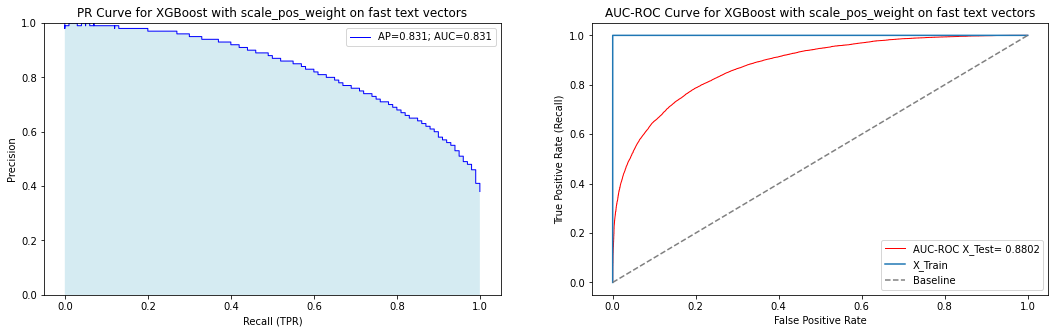

In [21]:
get_model_results(xgb_model, 
                  X_train_sm, 
                  X_test_sm, 
                  y_train_sm, 
                  y_test_sm, 
                  "XGBoost with scale_pos_weight on fast text vectors")

Add predict probas to df_train and df_test

In [22]:
xgb_probas_train = xgb_model.predict_proba(X_train_sm)
xgb_probas_test = xgb_model.predict_proba(X_test_sm)

xgb_probas_train_0 = [x[0] for x in xgb_probas_train]
xgb_probas_test_0 = [x[0] for x in xgb_probas_test]

df_train['xgb_probas_0'] = xgb_probas_train_0
df_test['xgb_probas_0'] = xgb_probas_test_0
df_train

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,preprocessed_q1,preprocessed_q2,lev_dist,vectorize_q1,vectorize_q2,cos_dist,NER_q1,NER_q2,ner_score,xgb_probas_0
328940,328976,328978,328978,455596,42,How are the paint colors determined for rockets?,Why are rockets and boosters painted white?,0,how paint colors determined rockets,why rockets boosters painted white,1.000000,"[0.0038284918, 0.005488307, 0.080265135, 0.004...","[-0.015344532, -0.005179783, 0.05806112, 0.005...",0.146495,,,1.0,0.943099
56839,56844,56844,56844,99997,99998,What is the difference between mixed reality a...,What is the difference between virtual reality...,1,what difference mixed reality augmented reality,what difference virtual reality augmented real...,0.428571,"[0.0012934674, 0.026035944, 0.057721216, 0.006...","[0.002372168, 0.026234863, 0.054641474, 0.0031...",0.006019,,,1.0,0.058493
218504,218532,218534,218534,325159,98882,What do you think about Justin Bieber?,Why do people hate Justin Bieber?,0,what think justin bieber,why people hate justin bieber,0.666667,"[-0.011422301, -0.042896304, 0.08092886, -0.00...","[-0.018951826, -0.06855711, 0.07119731, -0.006...",0.092537,Justin Bieber,Justin Bieber,1.0,0.957078
186912,186931,186932,186932,285015,285016,How do you remove the Advanced Mac Cleaner app?,What is the best free 3D modelling app for Mac?,0,how remove advanced mac cleaner app,what best free 3d modelling app mac,0.923077,"[0.0012302289, -0.035560507, 0.071201615, -0.0...","[-0.0031155734, 0.029179085, 0.061944075, -0.0...",0.228355,Advanced Mac Cleaner,Mac,-1.0,0.968591
280979,281012,281014,281014,400723,400724,I hired Penisula accounting to help with accou...,I've had an EPF with my current company for ab...,0,hired penisula accounting help accounting need...,'ve epf current company 1.5 years 'm moving ab...,1.300000,"[-0.0019388713, -0.005371588, 0.058348846, 0.0...","[0.0012819517, -0.006549388, 0.06939865, 0.001...",0.081297,Penisula,EPF|about 1.5 years|EPF|EPF|PPF|NRI,-1.0,0.986554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283398,283431,283433,283433,48119,128723,Why do Christians sometimes put coins over the...,My history professor said Islam will take over...,0,why christians sometimes put coins eyes dead p...,history professor said islam take christianity...,1.066667,"[-0.0026580116, -0.05701655, 0.08654476, 0.009...","[-0.0062189624, -0.013293198, 0.04885128, -0.0...",0.199056,Christians,Islam|Christianity,-1.0,0.955879
89746,89752,89752,89752,150733,150734,What's the difference between puckered lips an...,Why do people purse their lips in thought?,0,what 's difference puckered lips pursed lips,why people purse lips thought,1.000000,"[0.0050511328, -0.00697237, 0.058628753, -0.00...","[-0.0012444182, -0.07415825, 0.08550842, -0.01...",0.200472,,,1.0,0.934555
26462,26466,26466,26466,17057,36847,How can discontinuing 500 and 1000 rupee will ...,How will the India demonetization of 500 and 1...,1,how discontinuing 500 1000 rupee help control ...,how india demonetization 500 1000 rupees notes...,0.526316,"[-0.0021929608, -0.025166525, 0.07937319, 0.00...","[-0.0019042577, -0.010948677, 0.078877956, 0.0...",0.090147,500 and 1000,India|500 and 1000 rupees,-1.0,0.002331
394779,394818,394821,394821,311714,527738,"Can somebody explain the Mathematics behind, w...",Where is the best place to find a Celsius to F...,0,somebody explain mathematics behind why -40 de...,where best place find celsius fahrenheit conve...,1.000000,"[0.00020256966, -0.018036066, 0.06067563, 0.00...","[0.0031643303, -0.012299277, 0.05778341, 0.015...",0.199610,Celsius,a Celsius to Fahrenheit,-1.0,0.972445


- Final classification XGBClassifier  on df_train['lev_dist','cos_dist', 'xgb_probas_0']

In [25]:
xgb_model3 = XGBClassifier(max_depth=50, n_estimators=80, 
                              learning_rate=0.1, colsample_bytree=.7, 
                              gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1,scale_pos_weight =scale_pos_w, subsample=0.8)


xgb_model3.fit(df_train[['lev_dist','cos_dist', 'xgb_probas_0']], y_train_sm, 
              early_stopping_rounds=3, 
              eval_metric=["error", "logloss"], 
              eval_set=[(df_train[['lev_dist','cos_dist', 'xgb_probas_0']], y_train_sm), (df_test[['lev_dist','cos_dist', 'xgb_probas_0']], y_test_sm)], 
              verbose=True)

y_pred_sm3 = xgb_model3.predict(df_test[['lev_dist','cos_dist', 'xgb_probas_0']])

print('training score:', f1_score(y_train_sm, xgb_model3.predict(df_train[['lev_dist','cos_dist', 'xgb_probas_0']]), average='macro'))
print('test score:', f1_score(y_test_sm,y_pred_sm3, average='macro'))
print(classification_report(y_test_sm, y_pred_sm3))

[0]	validation_0-error:0.297376	validation_0-logloss:0.669051	validation_1-error:0.31337	validation_1-logloss:0.669782
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 3 rounds.
[1]	validation_0-error:0.30231	validation_0-logloss:0.649607	validation_1-error:0.315226	validation_1-logloss:0.650997
[2]	validation_0-error:0.303459	validation_0-logloss:0.633554	validation_1-error:0.315102	validation_1-logloss:0.635657
[3]	validation_0-error:0.30331	validation_0-logloss:0.620105	validation_1-error:0.315399	validation_1-logloss:0.622903
[4]	validation_0-error:0.158608	validation_0-logloss:0.536833	validation_1-error:0.235646	validation_1-logloss:0.577842
[5]	validation_0-error:0.184057	validation_0-logloss:0.527606	validation_1-error:0.248114	validation_1-logloss:0.568642
[6]	validation_0-error:0.024053	validation_0-logloss:0.460877	validation_1-error:0.194558	validation_1-logloss:0.533537

              precision    recall  f1-score   support

           0       0.86      0.79      0.83     25501
           1       0.69      0.78      0.73     14924

    accuracy                           0.79     40425
   macro avg       0.77      0.79      0.78     40425
weighted avg       0.80      0.79      0.79     40425



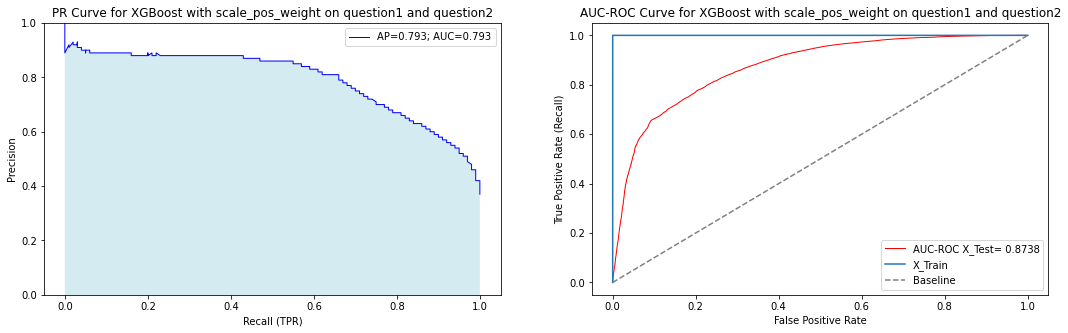

In [26]:
get_model_results(xgb_model3, 
                  df_train[['lev_dist','cos_dist', 'xgb_probas_0']], 
                  df_test[['lev_dist','cos_dist', 'xgb_probas_0']], 
                  y_train_sm, 
                  y_test_sm, 
                  "XGBoost with scale_pos_weight on question1 and question2")